# Experimentation Notebook

In this notebook we complete the experimentation process data scientists would preform to create a model. The [dataset](../datasets/covertype/README.md) used is based on **Covertype Data Set** from UCI Machine Learning Repository.

The training code uses `scikit-learn` for data pre-processing and modeling.

## Imports

In [33]:
import json
import numpy as np
import pandas as pd
import pickle
import uuid
import time
import seaborn as sns
import matplotlib.pyplot as plt

from jinja2 import Template
from typing import NamedTuple

from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## Data Import
This demo uses data from an open source database which is stored in a public bucket.  

In [34]:
DATA_ROOT = 'gs://workshop-datasets/covertype'
TRAINING_FILE_PATH = DATA_ROOT + '/training/dataset.csv'
VALIDATION_FILE_PATH = DATA_ROOT + '/evaluation/dataset.csv'

In [35]:
df_train = pd.read_csv(TRAINING_FILE_PATH)
df_validation = pd.read_csv(VALIDATION_FILE_PATH)

## Explore the Covertype dataset 

In [36]:
df_train

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2989,329,11,342,74,2861,194,227,172,1471,Commanche,C7756,2
1,3223,264,7,228,41,968,203,243,179,190,Commanche,C7756,1
2,3208,322,22,162,13,2876,158,212,191,2486,Rawah,C7745,1
3,3041,52,11,67,4,2467,226,217,124,3036,Commanche,C7700,2
4,2988,259,28,242,75,5197,143,242,231,1425,Rawah,C7745,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431004,2476,67,31,268,122,666,233,163,39,721,Commanche,C4703,2
431005,3029,130,7,30,4,3266,233,236,136,5388,Rawah,C7102,2
431006,3017,107,9,242,46,4265,235,230,126,1052,Rawah,C7746,2
431007,3314,144,16,362,56,1549,241,235,119,2911,Rawah,C7745,1


In [37]:
print(df_train.shape)
print(df_validation.shape)

(431009, 13)
(75000, 13)


### Visualize Data 

Selected plots have been created to illustrate the data exploration and analysis process

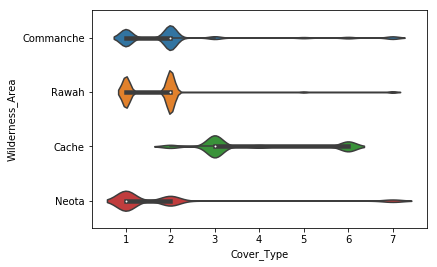

In [38]:
sns.violinplot(data=df_train,x='Cover_Type', y='Wilderness_Area')

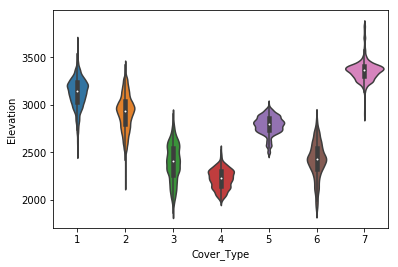

In [29]:
sns.violinplot(data=df_train,x='Cover_Type', y='Elevation')  

## Develop the training application

### Configure the `sklearn` training pipeline.

The training pipeline preprocesses data by standardizing all numeric features using `sklearn.preprocessing.StandardScaler` and encoding all categorical features using `sklearn.preprocessing.OneHotEncoder`. It uses stochastic gradient descent linear classifier (`SGDClassifier`) for modeling.

In [30]:
numeric_feature_indexes = slice(0, 10)
categorical_feature_indexes = slice(10, 12)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feature_indexes),
        ('cat', OneHotEncoder(), categorical_feature_indexes) 
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss='log'))
])

### Convert all numeric features to `float64`

To avoid warning messages from `StandardScaler` all numeric features are converted to `float64`.

In [31]:
num_features_type_map = {feature: 'float64' for feature in df_train.columns[numeric_feature_indexes]}

df_train = df_train.astype(num_features_type_map)
df_validation = df_validation.astype(num_features_type_map)

### Run the pipeline locally.

In [ ]:
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']
X_validation = df_validation.drop('Cover_Type', axis=1)
y_validation = df_validation['Cover_Type']

pipeline.set_params(classifier__alpha=0.001, classifier__max_iter=200)
pipeline.fit(X_train, y_train)

### Calculate the trained model's accuracy.
This model has an accuracy of ~70% which is pretty good for a 7 category classification problem. New features and different models could be tested to potentially develop a model with better performance. However for this excersies this is sufficient. 

In [ ]:
accuracy = pipeline.score(X_validation, y_validation)
print(accuracy)

# Next: Productionising the model

Now that we are happy with the models performance, we want to productionise the model